# Glide Performance

- How often does Glide sample a native pose?
- How often does Glide correctly score a native pose?

In [12]:
import sys
import os
import numpy as np
from shared_paths import shared_paths
import matplotlib.pyplot as plt

sys.path.append('../3_analyze')
from containers import LigandManager

%matplotlib inline

# Load docking data

In [13]:
prots = os.listdir('../../data')
prots.remove('M3') # Preprocessing failed, currently debugging
prots

['GCR',
 'BRAF',
 'DTRANSP',
 'AR',
 'MEK1',
 '5HT2B',
 'CDK2',
 'SIGMA1',
 'JAK2',
 'ERA',
 'PLK1',
 'VITD',
 'GLUT1',
 'MGLUR5',
 'STRANSP',
 'B2AR',
 'TRPV1',
 'MR',
 'B1AR',
 'CHK1']

In [137]:
data = Dataset(shared_paths, prots)

In [138]:
for prot in prots:
    lm = LigandManager(shared_paths, prot)
    data.load({prot: lm.pdb}, {prot: [lm.st]}, load_fp = False, load_mcss = False)

/scratch/PI/rondror/jpaggi/combind/data/ERA/docking/glide12 1L2I_lig 1A52
/scratch/PI/rondror/jpaggi/combind/data/ERA/docking/glide12/1L2I_lig-to-1A52 /scratch/PI/rondror/jpaggi/combind/data/ERA/ifp/ifp3/1L2I_lig-to-1A52.fp


In [151]:
glide = {}
for prot_name, protein in data.proteins.items():
    struct = protein.lm.st
    docking = protein.docking[struct]
    prot_key = struct+'_'+prot_name
    glide[prot_key] = {}
    for lig_name, ligand in docking.ligands.items():
        glide[prot_key][lig_name] = np.array(map(lambda x: x.rmsd, ligand.poses))

# How often does Glide sample a correct pose?

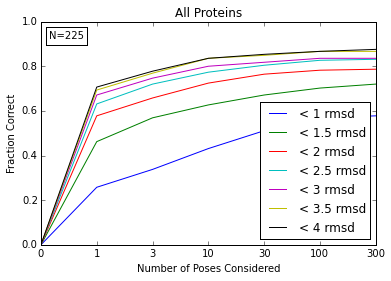

In [152]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

def add_at(ax, t, loc=2):
    fp = dict(size=10)
    _at = AnchoredText(t, loc=loc, prop=fp)
    ax.add_artist(_at)
    return _at

def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

rmsds = [rmsd for prot, ligands in glide.items() for lig, rmsd in ligands.items()
         if lig.split('_')[0] != prot.split('_')[0]]

POSES = [0, 1, 3, 10, 30, 100, 300]

f, ax = plt.subplots()

for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    Y = [percentage_native(rmsds, poses, thresh)
         for poses in POSES]
    ax.plot(Y, label = "< {} rmsd".format(thresh))
ax.set_xticklabels(POSES)
ax.legend(loc = 4)
ax.set_ylabel('Fraction Correct')
ax.set_xlabel('Number of Poses Considered')
ax.set_title('All Proteins')
ax.set_ylim(0, 1)
add_at(ax, "N={}".format(len(rmsds)))

In [153]:
class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print s

potential = Table([10]*4)
potential(['RMSD', 'top 1', 'top 100', 'Potential'])

rmsds = [rmsd for prot, ligands in glide.items() for lig, rmsd in ligands.items()
         if lig.split('_')[0] != prot.split('_')[0]]
for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    potential([thresh,
               percentage_native(rmsds, 1, thresh),
               percentage_native(rmsds, 100, thresh), 
               percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh)
              ])

RMSD      top 1     top 100   Potential 
1         0.2577777 0.5688888 0.3111111 
1.5       0.4622222 0.7022222 0.24      
2         0.5777777 0.7822222 0.2044444 
2.5       0.6311111 0.8266666 0.1955555 
3         0.6711111 0.8355555 0.1644444 
3.5       0.6933333 0.8666666 0.1733333 
4         0.7066666 0.8666666 0.16      


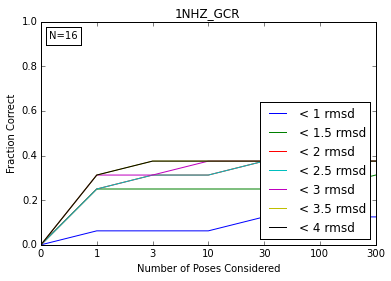

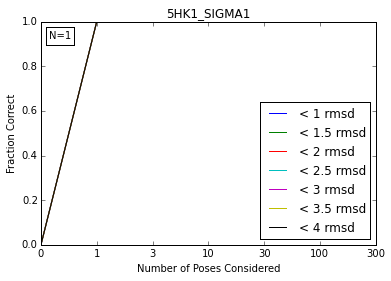

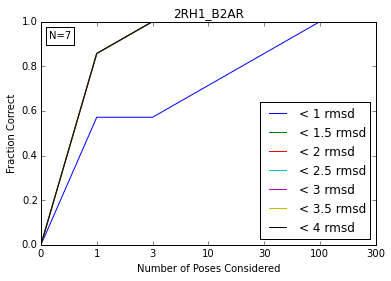

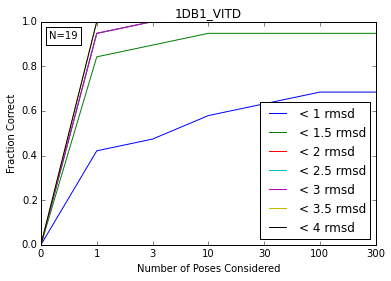

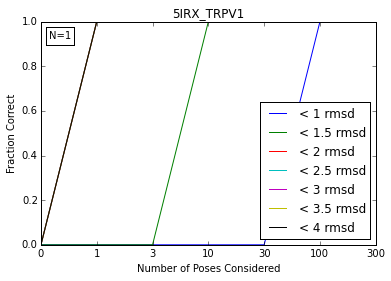

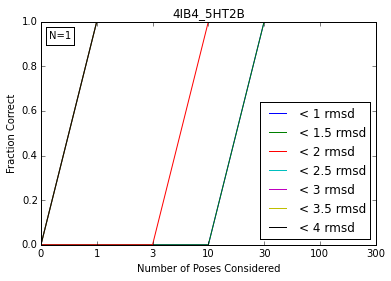

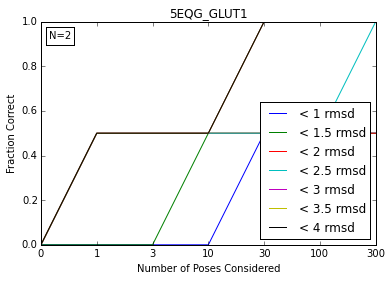

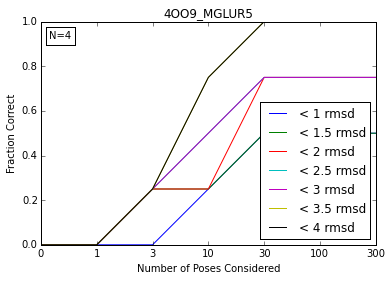

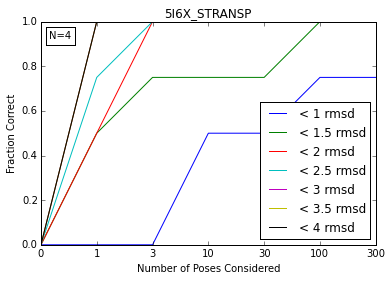

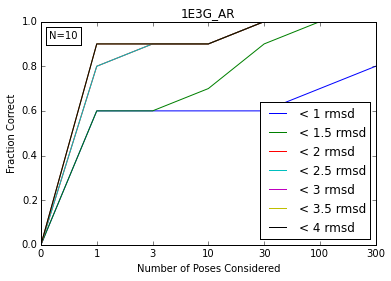

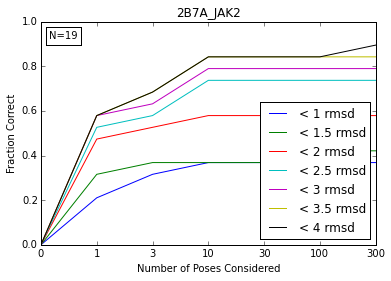

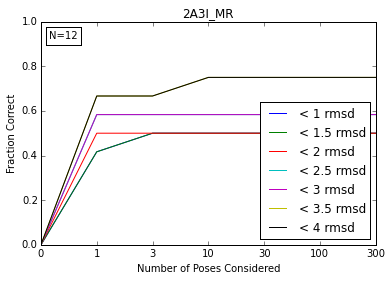

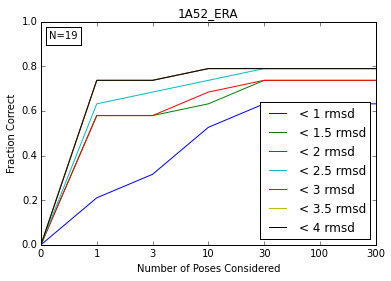

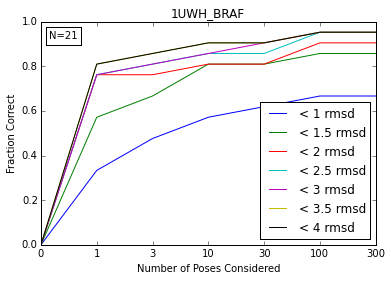

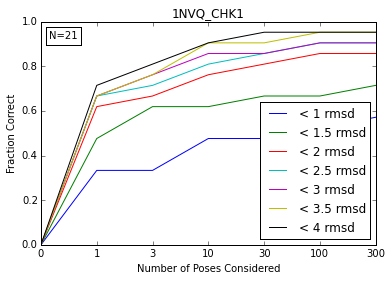

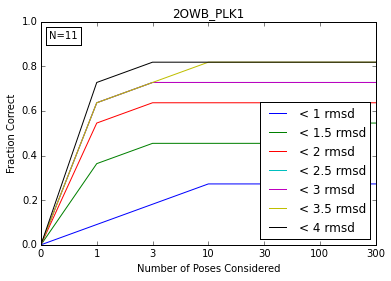

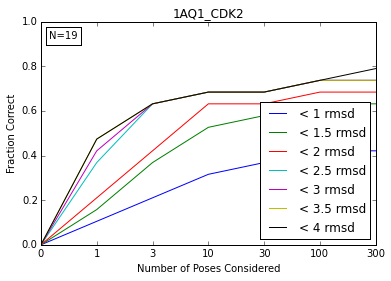

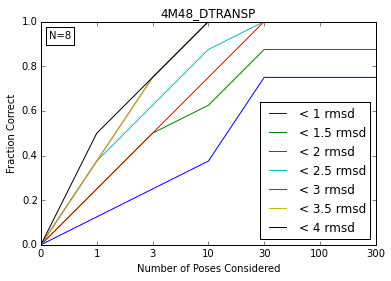

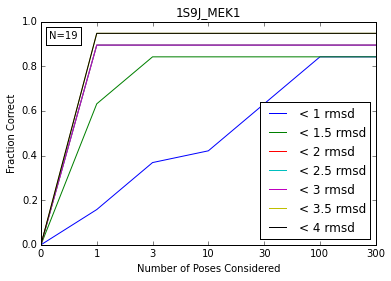

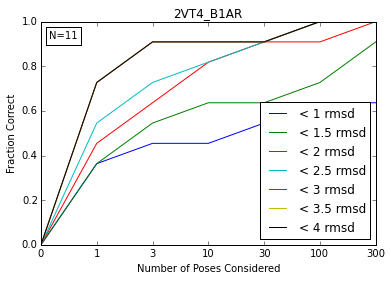

In [142]:
POSES = [0, 1, 3, 10, 30, 100, 300]

for prot, ligands in glide.items():
    rmsds = [rmsd for lig, rmsd in ligands.items()
             if lig.split('_')[0] != prot.split('_')[0]]
    f, ax = plt.subplots()
    for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSES]
        ax.plot(Y, label = "< {} rmsd".format(thresh))
    ax.set_xticklabels(POSES)
    ax.legend(loc = 4)
    ax.set_ylabel('Fraction Correct')
    ax.set_xlabel('Number of Poses Considered')
    ax.set_title(prot)
    ax.set_ylim(0, 1)
    add_at(ax, "N={}".format(len(rmsds)))
    plt.show()

In [155]:
thresh = 2.0

t = Table([15, 8, 8, 8])
t(['Protein', 'N', 'top 1', 'top 100'])

for prot, ligands in glide.items():
    rmsds = [rmsd for lig, rmsd in ligands.items()
             if lig.split('_')[0] != prot.split('_')[0]]
    t([prot,
       len(rmsds),
       percentage_native(rmsds, 1, thresh),
       percentage_native(rmsds, 100, thresh)])

Protein        N       top 1   top 100 
1NHZ_GCR       16      0.25    0.375   
5HK1_SIGMA1    1       1.0     1.0     
2RH1_B2AR      7       0.85714 1.0     
1DB1_VITD      19      0.94736 1.0     
5IRX_TRPV1     1       1.0     1.0     
4IB4_5HT2B     1       0.0     1.0     
5EQG_GLUT1     2       0.5     0.5     
4OO9_MGLUR5    4       0.0     0.75    
5I6X_STRANSP   4       0.5     1.0     
1E3G_AR        10      0.8     1.0     
2B7A_JAK2      19      0.47368 0.57894 
2A3I_MR        12      0.5     0.5     
1A52_ERA       19      0.57894 0.73684 
1UWH_BRAF      21      0.76190 0.90476 
1NVQ_CHK1      21      0.61904 0.85714 
2OWB_PLK1      11      0.54545 0.63636 
1AQ1_CDK2      19      0.21052 0.68421 
4M48_DTRANSP   8       0.25    1.0     
1S9J_MEK1      19      0.89473 0.89473 
2VT4_B1AR      11      0.45454 0.90909 


# Self-docking

In [157]:
for prot in ['AR']:
    lm = LigandManager(shared_paths, prot)
    data.load({prot: lm.pdb}, {prot: lm.grids}, load_fp = False, load_mcss = False)

In [158]:
glide = {}
for prot_name, protein in data.proteins.items():
    glide[prot_name] = {}
    for struct, docking in protein.docking.items():
        lig_name = "{}_lig".format(struct)
        if lig_name not in docking.ligands: continue
        ligand = docking.ligands[lig_name]
        glide[prot_name][lig_name] = np.array(map(lambda x: x.rmsd, ligand.poses))

In [159]:
len(glide['AR'])

18

In [160]:
glide

{'5HT2B': {'4IB4_lig': array([  0.66096979,   0.99521663,   0.94975658,   0.74564438,
           0.27982986,   0.93916913,   0.21099387,   1.06708005,
           0.41618485,   0.96639809,   0.9393582 ,   0.9022258 ,
           0.82769365,   0.74114603,   1.00653791,   0.71226495,
           0.61032588,   0.67427124,   0.6543025 ,   1.08877055,
           0.81243106,   1.99447385,   1.97388391,   4.36066573,
           2.47687632,   9.7763242 ,   2.06855141,   2.52367085,
           5.01846329,   3.64087522,   9.84813493,   2.36389081,
           3.2294533 ,   2.29609875,   2.93794322,  10.64212635,
          10.8981047 ,  13.33557322])},
 'AR': {'1E3G_lig': array([ 0.12379439,  0.14282184,  0.14744786,  0.14762518,  0.14787595,
          0.14828831,  0.14443464,  0.14640917,  0.14310535,  0.15440728,
          0.14409215,  0.12915087,  0.14755842,  0.14568643,  0.15097878,
          0.14414428,  0.14900585,  0.14437338,  0.14537073,  0.14902931,
          0.15176672,  0.14945086,  0.14

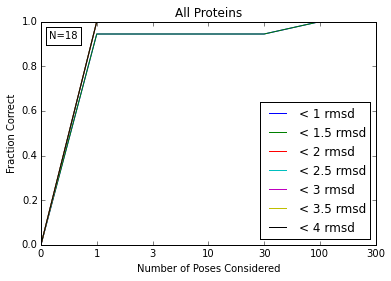

In [162]:
rmsds = [rmsd for prot, ligands in glide.items() for lig, rmsd in ligands.items() if prot == 'AR']

POSES = [0, 1, 3, 10, 30, 100, 300]

f, ax = plt.subplots()

for thresh in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    Y = [percentage_native(rmsds, poses, thresh)
         for poses in POSES]
    ax.plot(Y, label = "< {} rmsd".format(thresh))
ax.set_xticklabels(POSES)
ax.legend(loc = 4)
ax.set_ylabel('Fraction Correct')
ax.set_xlabel('Number of Poses Considered')
ax.set_title('All Proteins')
ax.set_ylim(0, 1)
add_at(ax, "N={}".format(len(rmsds)))
plt.show()